# 3_modeling_evaluation_suto

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import mean_absolute_error, mean_squared_error

path_data = "../data/raw/"
path_interim_data = "../data/interim/"

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [2]:
df_data = pd.read_parquet(path_interim_data+"df_data_step_2_output.pqt")

print(f"Dimensões do dataset: {df_data.shape}")

df_data.head()

Dimensões do dataset: (397, 6)


,displacement,horsepower,weight,acceleration,origin,mpg
0,360.0,175.0,3821.0,11.0,1.0,13.0
1,390.0,190.0,3850.0,8.5,1.0,15.0
2,304.0,150.0,3672.0,11.5,1.0,17.0
3,232.0,90.0,3210.0,17.2,1.0,19.4
4,151.0,90.0,3003.0,20.1,1.0,24.3


## Regressão linear simples

Verificando a relação de cada fator/variável de entrada/preditor contínuo sobre a resposta/variável de saída.

**IMPORTANTE**: nesse momento, estamos apenas avaliando os fatores contínuos.

In [48]:
ls_continuous_features = df_data.select_dtypes(include=[float]).columns

ls_continuous_features = sorted(ls_continuous_features)

lst_continuas_sem_mpg = [feature for feature in ls_continuous_features if feature not in ['mpg', 'origin']]

In [52]:
# Criando um dataset com valores de X igualmente espaçados para gerar as retas.

df_reg = pd.DataFrame()

for feature in df_data[lst_continuas_sem_mpg].columns:
    min_temp = int(df_data[feature].min()*.95)
    max_temp = int(df_data[feature].max()*1.05)
    df_reg[feature] = np.linspace(min_temp, max_temp, num=100, endpoint=True)

In [53]:
# Obtendo as equações de reta para cada relação "fator vs 'mpg'".

X = df_data[lst_continuas_sem_mpg]
y = df_data["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

dct_equations = {}

for feature in df_data[lst_continuas_sem_mpg].columns:
    model = LinearRegression()
    model.fit(X_train[feature].values.reshape(-1, 1), y_train)
    dct_equations[feature] = str(round(model.intercept_, 3)) + " + (" + str(round(model.coef_[0], 3)) + ")"
    df_reg["y_pred_mpg_"+feature] = model.predict(df_reg[feature].values.reshape(-1, 1))
    
print(f"Dimensão da matriz: {df_reg.shape}")

Dimensão da matriz: (100, 8)


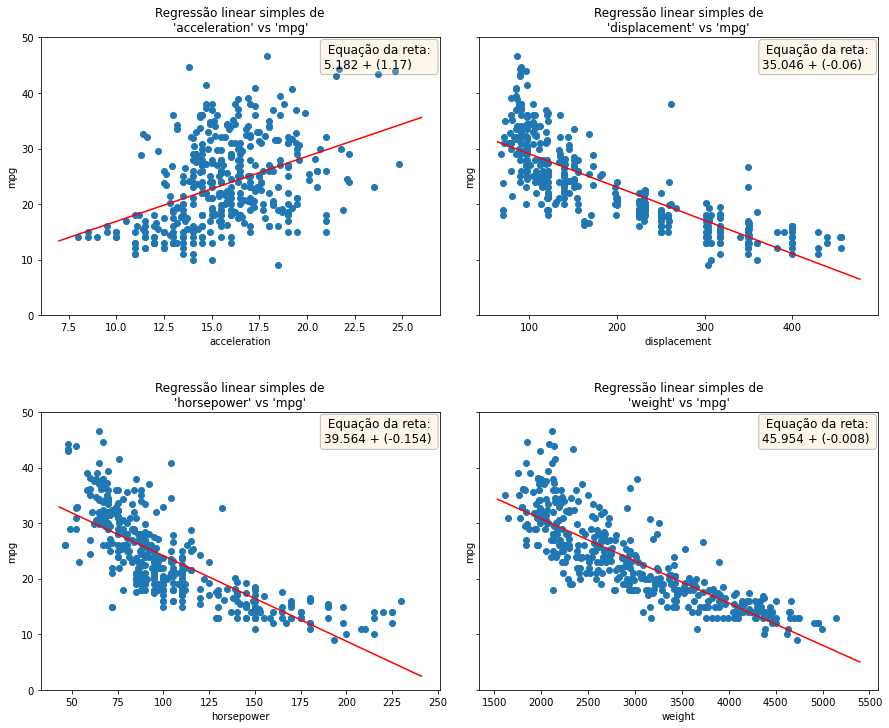

In [57]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,12), sharey=True, gridspec_kw={'hspace': .35, 'wspace': .1})

row = col = 0

for i, feature in enumerate(df_data[lst_continuas_sem_mpg].columns):
    axs[row, col].scatter(data=df_data, x=feature, y="mpg")
    axs[row, col].plot(df_reg[feature], df_reg["y_pred_mpg_"+feature], color='red')
    axs[row, col].set(title="Regressão linear simples de\n'"+feature+"' vs 'mpg'",
                      ylim=[0,50], xlabel=feature);
            
    textstr = f""" Equação da reta: \n{dct_equations[feature]}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    
    axs[row, col].text(.71, 0.98, textstr, transform=axs[row, col].transAxes, fontsize=12,
        verticalalignment='top', bbox=props);

    if (i+1)%2!=0:
        col += 1
    else:
        col = 0
        row+=1
        
for ax in axs.flat:
    ax.set(ylabel='mpg')

### Avaliando os modelos obtidos

Para cada modelo de regressão linear obtido, avaliaremos utilizando duas métricas:
- R²
- RMSE (Raiz do erro quadrático médio)

In [58]:
# TODO:

### Regressão linear múltipla

Verificando o impacto de dois ou mais fatores/variáveis de entrada sobre a reposta/variável de saída.

In [6]:
X = df_data[lst_continuas_sem_mpg]
y = df_data["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train);

In [7]:
cv = 3
scoring = "neg_root_mean_squared_error"
# "neg_mean_squared_error", "r2"

n_scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"MSE: média: {n_scores.mean():.3f}, desvio padrão: {n_scores.std():.3f}")

MSE: média: -4.247, desvio padrão: 0.354


In [8]:
y_pred = model.predict(X_test)

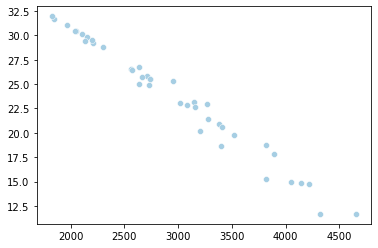

In [9]:
sns.set_palette(set_palette)
sns.axes_style(axes_style)

ax = sns.scatterplot(x=X_test["weight"].values, y=y_pred)
